In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("/Users/piyush/projects/ViDA-SSL/")

In [43]:
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.io import load_json, load_txt

In [71]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [4]:
annot_path = "/Users/piyush/projects/ViDA-SSL/data/FineGym/annotations"\
    "/action-temporal-localization/finegym_annotation_info_v1.0.json"
train_split_file = "/Users/piyush/projects/ViDA-SSL/data/FineGym/splits/gym99_train.txt"
val_split_file = "/Users/piyush/projects/ViDA-SSL/data/FineGym/splits/gym99_val.txt"

In [5]:
annot = load_json(annot_path)

In [6]:
len(annot)

303

In [7]:
events = []
stages = []
segment_times = []

subactions = dict()

for vkey in annot:
    edict = annot[vkey]
    for ekey in edict:
        events.append(annot[vkey][ekey]["event"])

        segments = edict[ekey]["segments"]
        if segments is not None:
            for skey in segments:
                stages.append(segments[skey]["stages"])
                
                tstamps = segments[skey]["timestamps"]
                segment_times.extend([x[1] - x[0] for x in tstamps])

In [8]:
len(segment_times)

36764

In [9]:
np.mean(segment_times)

1.545762974649113

### Duration

In [13]:
subaction_times = dict()

video_keys = annot.keys()

for vkey in video_keys:
    
    event_keys = annot[vkey].keys()
    
    for ekey in event_keys:
        
        subact_dict = annot[vkey][ekey]["segments"]
        if subact_dict is not None:
            for skey, sval in subact_dict.items():
                instance_key = f"{vkey}_{ekey}_{skey}"
                subaction_times[instance_key] = sval["timestamps"]

In [14]:
len(subaction_times)

32697

In [15]:
list(subaction_times.keys())[:10]

['0LtLS9wROrk_E_002407_002435_A_0003_0005',
 '0LtLS9wROrk_E_002407_002435_A_0006_0008',
 '0LtLS9wROrk_E_002407_002435_A_0012_0013',
 '0LtLS9wROrk_E_002407_002435_A_0015_0017',
 '0LtLS9wROrk_E_002407_002435_A_0019_0021',
 '0LtLS9wROrk_E_002407_002435_A_0021_0023',
 '0LtLS9wROrk_E_002407_002435_A_0023_0028',
 '0LtLS9wROrk_E_002451_002529_A_0019_0021',
 '0LtLS9wROrk_E_002451_002529_A_0022_0023',
 '0LtLS9wROrk_E_002451_002529_A_0033_0034']

In [16]:
subaction_times["0LtLS9wROrk_E_002407_002435_A_0015_0017"]

[[15.59, 17.27]]

### Load split files

In [35]:
train_split = load_txt(train_split_file)
train_ids = [x.split()[0] for x in train_split]
train_labels = [x.split()[1] for x in train_split]

val_split = load_txt(val_split_file)
val_ids = [x.split()[0] for x in val_split]
val_labels = [x.split()[1] for x in val_split]

In [36]:
len(train_ids), len(val_ids), len(train_labels)

(20484, 8521, 20484)

In [19]:
train_ids[0] in subaction_times, \
val_ids[0] in subaction_times

(True, True)

In [37]:
split_ids = train_ids + val_ids
split_labels = train_labels + val_labels

### Filter based on given split

In [21]:
split_subaction_times = {k:v for k, v in subaction_times.items() if k in split_ids}

In [22]:
len(split_subaction_times)

29005

In [23]:
total_times = []
for key, value in split_subaction_times.items():
    total_times.extend([x[1] - x[0] for x in value])

In [24]:
len(total_times)

32045

In [25]:
np.mean(total_times)

1.5071196754563894

In [26]:
len(split_subaction_times.keys())

29005

In [27]:
list(split_subaction_times.keys())[0]

'0LtLS9wROrk_E_002407_002435_A_0003_0005'

In [28]:
len(split_ids)

29005

In [29]:
split_ids[0]

'A0xAXXysHUo_E_002184_002237_A_0035_0036'

### Label distribution

In [34]:
len(np.unique(split_ids)), \
len(np.unique([x.split("_E_")[0] for x in split_ids])), \
len(np.unique([x.split("_E_")[-1].split("_A_")[0] for x in split_ids])), \
len(np.unique([x.split("_A_")[-1] for x in split_ids]))

(29005, 180, 4307, 551)

In [42]:
len(split_labels), len(np.unique(split_labels))

(29005, 99)

In [45]:
df = pd.DataFrame(None)
df["id"] = split_ids
df["label"] = split_labels

In [54]:
df.label.value_counts().index

Index(['95', '79', '67', '94', '76', '43', '47', '68', '59', '64', '40', '55',
       '1', '62', '8', '15', '2', '38', '78', '89', '35', '6', '74', '96',
       '88', '46', '34', '63', '91', '52', '66', '61', '50', '60', '28', '10',
       '71', '58', '37', '41', '86', '30', '98', '32', '92', '24', '31', '25',
       '21', '22', '7', '75', '83', '9', '3', '85', '77', '44', '51', '69',
       '17', '18', '16', '90', '84', '53', '87', '4', '33', '27', '36', '14',
       '81', '11', '49', '80', '26', '82', '12', '20', '97', '56', '13', '73',
       '5', '57', '42', '93', '45', '65', '39', '72', '54', '48', '70', '0',
       '19', '23', '29'],
      dtype='object')

In [61]:
-df.groupby('label').label.transform('size')

0        -88
1       -163
2       -809
3       -565
4       -809
        ... 
29000    -77
29001    -77
29002    -77
29003    -77
29004    -77
Name: label, Length: 29005, dtype: int64

In [65]:
sort_df = df.iloc[(-df.groupby('label').label.transform('size')).argsort(kind='mergesort')]

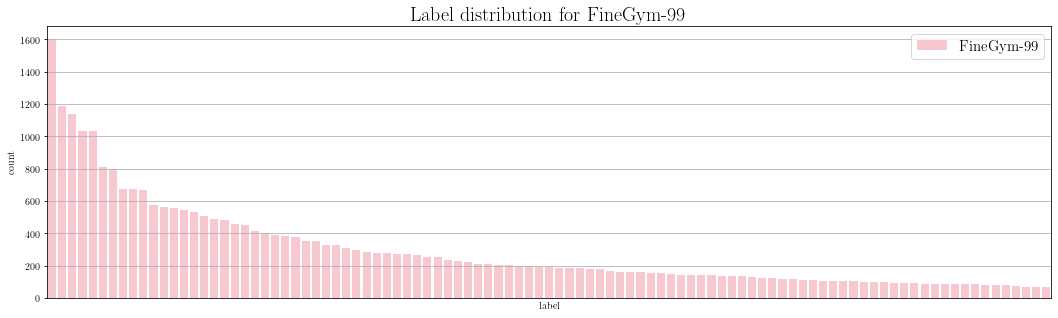

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))

ax.grid()
sns.countplot(data=sort_df, x=f"label", ax=ax, label="FineGym-99", color="pink")
ax.set_title("Label distribution for FineGym-99", fontsize=20)
ax.legend(fontsize=15)
ax.set_xticks([])

plt.show()